<a href="https://colab.research.google.com/github/ashibullah/Romanian-Bangla-Sentiment-Analysis-NLP/blob/main/RomanianBanglaSentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data collection + libraries

In [ ]:
!pip install datasets --upgrade
!pip install imbalanced-learn
!pip install nltk
!pip install tensorflow nltk #lstm
!pip install imbalanced-learn xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [ ]:
import nltk
nltk.download('punkt_tab')  # For tokenizer
nltk.download('stopwords')  # For tokenizer

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# --- Text Processing ---
import re
import json
import nltk
from nltk.tokenize import word_tokenize
from textblob import TextBlob
nltk.download('punkt')

# --- Data Manipulation ---
import pandas as pd
import numpy as np
from collections import Counter

# --- Scikit-learn: Model Selection, ML Algorithms, and Metrics ---
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight, compute_class_weight
from sklearn.metrics import classification_report

# --- Handling Imbalanced Data ---
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# --- XGBoost ---
from xgboost import XGBClassifier

# --- TensorFlow / Keras: Deep Learning ---
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, Bidirectional, LSTM,
    Conv1D, GlobalMaxPooling1D,
    Dense, Dropout
)
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from datasets import load_dataset

df = load_dataset("aplycaebous/BnSentMix" , split = "train")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

dataset.csv:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20015 [00:00<?, ? examples/s]

# **Preprocessing**

In [ ]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [ ]:
def correct_text(text):
    return str(TextBlob(text).correct())

In [ ]:
# Create DataFrame
df = pd.DataFrame(df)
# Convert 'Sentence' column to lowercase
df['Sentence'] = df['Sentence'].str.lower()

# remove urls
df['Sentence'] = df['Sentence'].apply(clean_text)


In [ ]:
def reduce_repeated_letters(word, max_repeats=2):
    # This will limit repeated letters to max_repeats (e.g., 'ooooo' -> 'oo')
    return re.sub(r'(.)\1{'+str(max_repeats)+',}', r'\1' * max_repeats, word)


def reduce_repeats_in_sentence(sentence):
    return ' '.join([reduce_repeated_letters(word) for word in sentence.split()])

df['Sentence'] = df['Sentence'].apply(reduce_repeats_in_sentence)

In [ ]:
dict_path = '/content/drive/MyDrive/Colab Notebooks/RomanianBanglaUtilities/normalization_dict.json'
with open(dict_path, 'r', encoding='utf-8') as f:
    normalization_dict = json.load(f)

print(f"Loaded normalization dictionary with {len(normalization_dict)} entries")


# Function to normalize text using your dictionary
def normalize_text(text, norm_dict):
    tokens = text.split()
    reverse_map = {}
    for std_word, variants in norm_dict.items():
        reverse_map[std_word] = std_word
        for var in variants:
            reverse_map[var] = std_word
    normalized_tokens = [reverse_map.get(token.lower(), token.lower()) for token in tokens]
    return ' '.join(normalized_tokens)
# run
df['Sentence'] = df['Sentence'].apply(lambda x: normalize_text(x, normalization_dict))


Loaded normalization dictionary with 59 entries


In [ ]:
abbrev_path = '/content/drive/MyDrive/Colab Notebooks/RomanianBanglaUtilities/abbreviation.json'
with open(abbrev_path, 'r', encoding='utf-8') as f:
    abbreviation_dict = json.load(f)

print(f"Loaded abbreviation dictionary with {len(abbreviation_dict)} entries")

# Function to normalize text using abbreviation dictionary
def normalize_abbreviations(text, abbr_dict):
    tokens = text.split()
    normalized_tokens = [abbr_dict.get(token.lower(), token) for token in tokens]
    return ' '.join(normalized_tokens)

    # run
    df['Sentence'] = df['Sentence'].apply(lambda x: normalize_abbreviations(x, abbreviation_dict))

Loaded abbreviation dictionary with 72 entries


# **Feature Extraction Starts Here**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import re

# Step 1: Vectorize and extract vocabulary
vectorizer = CountVectorizer(lowercase=True)
vectorizer.fit(df['Sentence'])

# Step 2: Get raw vocab
raw_vocab = vectorizer.get_feature_names_out()

# Step 3: Filter to keep only clean alphabetic words
def is_clean_word(word):
    return re.fullmatch(r'[a-zA-Z]+', word) is not None

clean_vocab = [word for word in raw_vocab if is_clean_word(word)]

print(f"Cleaned vocabulary size: {len(clean_vocab)}")

# Step 4: Save only cleaned vocab to txt file
with open("clean_vocab.txt", "w", encoding="utf-8") as f:
    for word in clean_vocab:
        f.write(f"{word}\n")

print("Cleaned vocabulary exported to clean_vocab.txt")

# Preview first 20 words
# print(clean_vocab[:20])


Cleaned vocabulary size: 26637
Cleaned vocabulary exported to clean_vocab.txt


Apply the clean vocab


In [ ]:
# Load clean vocab into a set
with open("clean_vocab.txt", "r", encoding="utf-8") as f:
    clean_vocab = set(f.read().splitlines())

# Filter each sentence based on clean vocab
def filter_text(text):
    return ' '.join([word for word in text.split() if word in clean_vocab])

df['Cleaned_Sentence'] = df['Sentence'].apply(filter_text)

# Tokenizer

In [ ]:
# # 1️⃣ TF-IDF
# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2), min_df=3)
# X_tfidf = tfidf.fit_transform(df['Sentence'])

# # 2️⃣ Bag of Words
# from sklearn.feature_extraction.text import CountVectorizer
# bow = CountVectorizer(max_features=10000, ngram_range=(1,2), min_df=3)
# X_bow = bow.fit_transform(df['Sentence'])

# # 3️⃣ Hashing Vectorizer
# from sklearn.feature_extraction.text import HashingVectorizer
# hash_vec = HashingVectorizer(n_features=10000, ngram_range=(1,2))
# X_hash = hash_vec.fit_transform(df['Sentence'])


In [ ]:
import matplotlib.pyplot as plt

def plot_confusion_matrix_fixed(y_true, y_pred, title="Confusion Matrix"):
    """
    Plots a confusion matrix for fixed class labels: Positive, Negative, Neutral, Mixed.

    Parameters:
    - y_true: array-like of shape (n_samples,)
        True labels.
    - y_pred: array-like of shape (n_samples,)
        Predicted labels.
    - title: str, optional
        Title of the confusion matrix plot.
    """
    fixed_labels = ["Positive", "Negative", "Neutral", "Mixed"]
    cm = confusion_matrix(y_true, y_pred, labels=range(len(fixed_labels)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=fixed_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()


# Save & Load Model Function

In [ ]:
import os
import pickle
import numpy as np

def save_lstm_model_assets(model, tokenizer, X_test, y_test, nameModel):
    """
    Save LSTM model, tokenizer, and test data to Google Drive.

    Parameters:
        model (tf.keras.Model): Trained Keras model
        tokenizer (Tokenizer): Fitted tokenizer object
        X_test (np.array): Test input data
        y_test (np.array): Test labels
        nameModel (str): Model name used to create a unique directory
    """
    # Set up directory
    save_dir = f'/content/drive/MyDrive/models/{nameModel}'
    os.makedirs(save_dir, exist_ok=True)

    # Save model
    model_path = os.path.join(save_dir, f'{nameModel}.h5')
    model.save(model_path)
    print(f"✅ Model saved to: {model_path}")

    # Save tokenizer
    tokenizer_path = os.path.join(save_dir, f'{nameModel}_tokenizer.pkl')
    with open(tokenizer_path, 'wb') as f:
        pickle.dump(tokenizer, f)
    print(f"✅ Tokenizer saved to: {tokenizer_path}")

    # Save test data
    np.save(os.path.join(save_dir, f'X_test_{nameModel}.npy'), X_test)
    np.save(os.path.join(save_dir, f'y_test_{nameModel}.npy'), y_test)
    print(f"✅ Test data saved to: {save_dir}")


In [ ]:
import os
import pickle
import numpy as np

def save_ml_model_assets(model, X_test, y_test, nameModel):
    """
    Save ML model and test data to Google Drive.

    Parameters:
        model: Trained scikit-learn model
        X_test (np.array): Test features
        y_test (np.array): Test labels
        nameModel (str): Directory name to save under
    """
    save_dir = f'/content/drive/MyDrive/models/{nameModel}'
    os.makedirs(save_dir, exist_ok=True)

    # Save model with pickle
    model_path = os.path.join(save_dir, f'{nameModel}_model.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"✅ ML Model saved to: {model_path}")

    # Save test data
    np.save(os.path.join(save_dir, f'X_test_{nameModel}.npy'), X_test)
    np.save(os.path.join(save_dir, f'y_test_{nameModel}.npy'), y_test)
    print(f"✅ Test data saved to: {save_dir}")


In [ ]:
import os
import numpy as np
import pickle
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def load_and_evaluate_lstm_model(nameModel, target_names=None):
    """
    Load LSTM model, tokenizer, and test data, then evaluate and display results.

    Parameters:
        nameModel (str): The name of the model directory (inside /MyDrive/models/)
        target_names (list): Optional list of class labels for the report and CM
    """
    # Set up paths
    base_dir = f'/content/drive/MyDrive/models/{nameModel}'
    model_path = os.path.join(base_dir, f'{nameModel}.h5')
    tokenizer_path = os.path.join(base_dir, f'{nameModel}_tokenizer.pkl')
    x_test_path = os.path.join(base_dir, f'X_test_{nameModel}.npy')
    y_test_path = os.path.join(base_dir, f'y_test_{nameModel}.npy')

    # Load model
    model = load_model(model_path)
    print(f"✅ Loaded model from: {model_path}")

    # Load tokenizer
    with open(tokenizer_path, 'rb') as f:
        tokenizer = pickle.load(f)
    print(f"✅ Loaded tokenizer from: {tokenizer_path}")

    # Load test data
    X_test = np.load(x_test_path)
    y_test = np.load(y_test_path)
    print(f"✅ Loaded test data from: {x_test_path} and {y_test_path}")

    # Predict
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Classification report
    if target_names is None:
        target_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']
    print(f'\n📊 Classification Report of {nameModel}')
    print(classification_report(y_test, y_pred, target_names=target_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix: {nameModel}')
    plt.show()


In [ ]:
import os
import pickle
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_evaluate_ml_model(nameModel, target_names=None):
    """
    Load a scikit-learn ML model, test data, and evaluate it.

    Parameters:
        nameModel (str): Folder name where the model and test data are stored
        target_names (list): Optional class labels for report and confusion matrix
    """
    base_dir = f'/content/drive/MyDrive/models/{nameModel}'

    # Load model
    model_path = os.path.join(base_dir, f'{nameModel}_model.pkl')
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    print(f"✅ Loaded model from: {model_path}")

    # Load test data
    X_test = np.load(os.path.join(base_dir, f'X_test_{nameModel}.npy'))
    y_test = np.load(os.path.join(base_dir, f'y_test_{nameModel}.npy'))
    print(f"✅ Loaded test data from: {base_dir}")

    # Predict
    y_pred = model.predict(X_test)

    # Classification report
    if target_names is None:
        target_names = [f'Class {i}' for i in np.unique(y_test)]
    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix: {nameModel}')
    plt.show()


# **DL ALGO's**

Resampled label distribution: Counter({np.int64(3): 6619, np.int64(2): 6619, np.int64(1): 6619, np.int64(0): 6619})
Epoch 1/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 98s 264ms/step - accuracy: 0.5239 - loss: 1.0503 - val_accuracy: 0.8102 - val_loss: 0.5088
Epoch 2/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 145s 274ms/step - accuracy: 0.8714 - loss: 0.3660 - val_accuracy: 0.8255 - val_loss: 0.4823
Epoch 3/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 142s 273ms/step - accuracy: 0.9383 - loss: 0.1886 - val_accuracy: 0.8439 - val_loss: 0.4700
Epoch 4/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 139s 264ms/step - accuracy: 0.9602 - loss: 0.1248 - val_accuracy: 0.8406 - val_loss: 0.5363
Epoch 5/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 143s 267ms/step - accuracy: 0.9700 - loss: 0.0987 - val_accuracy: 0.8457 - val_loss: 0.5558
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
              precision    recall  f1-score   support

    Positive       0.87      0.90      0.88       993
    Negative       0.79      0.77      0.78       993
     Neutral       0.81  

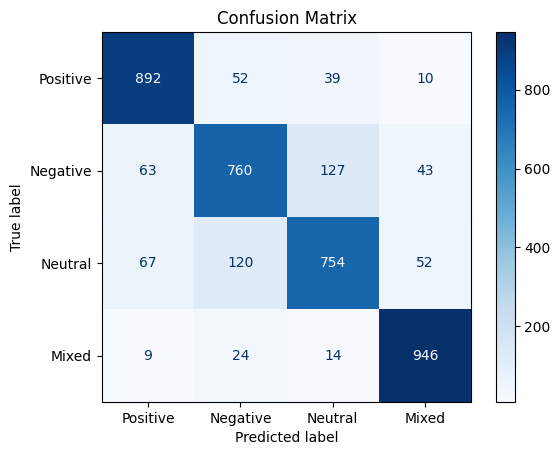

In [ ]:
# Assuming df is already loaded
texts = df['Sentence'].tolist()
labels = df['Label'].tolist()

# Tokenize and pad
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=100, padding='post')
y = np.array(labels).astype(int)

# Choose either 'oversample' or 'undersample'
SAMPLING_STRATEGY = 'oversample'  # Change to 'undersample' if needed

if SAMPLING_STRATEGY == 'oversample':
    sampler = RandomOverSampler(sampling_strategy='not majority', random_state=42)
elif SAMPLING_STRATEGY == 'undersample':
    sampler = RandomUnderSampler(sampling_strategy='not minority', random_state=42)
else:
    raise ValueError("Invalid SAMPLING_STRATEGY. Use 'oversample' or 'undersample'.")

X_resampled, y_resampled = sampler.fit_resample(X, y)
print(f"Resampled label distribution: {Counter(y_resampled)}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.15,
    stratify=y_resampled,
    random_state=42
)

# Convert to proper format
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Build model
model = Sequential([
    Embedding(input_dim=20000, output_dim=128),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  # Adjust based on actual class count
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Class weights (optional, not typically used with resampling)
class_weight_dict = None
if SAMPLING_STRATEGY == 'none':
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))

# Train
model.fit(
    X_train, y_train,
    epochs=8,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    class_weight=class_weight_dict
)
# Predict
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluation
print(classification_report(y_test, y_pred_classes, target_names=['Positive', 'Negative', 'Neutral', 'Mixed']))
# Confusion matrix function (you need to define or import this)
plot_confusion_matrix_fixed(y_test, y_pred_classes)

# LSTM

In [ ]:
texts = df['Sentence'].tolist()
# texts = df['Cleaned_Sentence'].tolist()
labels = df['Label'].tolist()

# Tokenize and pad
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
maxlen = 100
X = pad_sequences(sequences, maxlen=maxlen, padding='post')

y = np.array(labels)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
model = Sequential([
    Embedding(input_dim=20000, output_dim=128),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  # 4 sentiment classes
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()


oversampling

Training label distribution: Counter({np.int64(0): 5626, np.int64(3): 5626, np.int64(2): 5626, np.int64(1): 5626})
Epoch 1/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 106s 283ms/step - accuracy: 0.5396 - loss: 1.0253 - val_accuracy: 0.8082 - val_loss: 0.5217
Epoch 2/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 142s 282ms/step - accuracy: 0.8726 - loss: 0.3604 - val_accuracy: 0.8356 - val_loss: 0.4496
Epoch 3/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 140s 277ms/step - accuracy: 0.9364 - loss: 0.1979 - val_accuracy: 0.8432 - val_loss: 0.4893
Epoch 4/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 96s 273ms/step - accuracy: 0.9614 - loss: 0.1269 - val_accuracy: 0.8348 - val_loss: 0.5615
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step
              precision    recall  f1-score   support

    Positive       0.84      0.90      0.87       993
    Negative       0.79      0.75      0.77       993
     Neutral       0.79      0.76      0.77       993
       Mixed       0.92      0.93      0.93       993

    accuracy                           0.84     

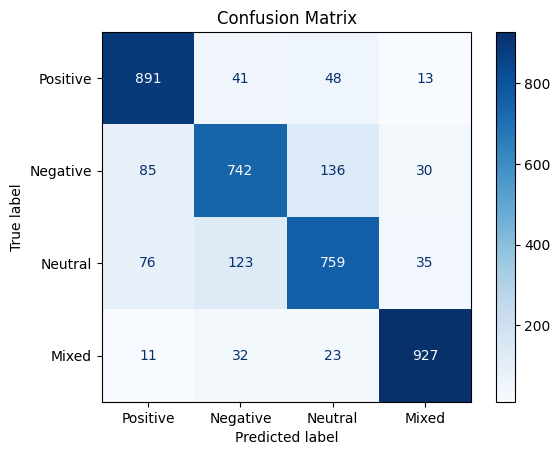

In [ ]:
ros = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.15,
    stratify=y_resampled,
    random_state=42
)


X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train).astype(int)
y_test = np.array(y_test).astype(int)
from collections import Counter
print("Training label distribution:", Counter(y_train))

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.fit(
    X_train, y_train,
    epochs=8,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=['Positive', 'Negative', 'Neutral', 'Mixed']))
plot_confusion_matrix_fixed(y_test, y_pred_classes)



In [ ]:
save_lstm_model_assets(model, tokenizer, X_test, y_test, 'lstmOverSampling')

✅ Model saved to: /content/drive/MyDrive/models/lstmOverSampling/lstmOverSampling.h5
✅ Tokenizer saved to: /content/drive/MyDrive/models/lstmOverSampling/lstmOverSampling_tokenizer.pkl
✅ Test data saved to: /content/drive/MyDrive/models/lstmOverSampling


Under Sampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Check original distribution
print("Original:", Counter(y))

# Apply undersampling
rus = RandomUnderSampler(sampling_strategy='not minority', random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Check new distribution
print("Undersampled:", Counter(y_resampled))


Original: Counter({np.int64(2): 6619, np.int64(1): 6172, np.int64(0): 5353, np.int64(3): 1871})
Undersampled: Counter({np.int64(0): 1871, np.int64(1): 1871, np.int64(2): 1871, np.int64(3): 1871})


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.15,
    stratify=y_resampled,
    random_state=42
)

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train your LSTM (you don't need class_weight here)
model.fit(
    X_train, y_train,
    epochs=8,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 280ms/step - accuracy: 0.9366 - loss: 0.1909 - val_accuracy: 0.9199 - val_loss: 0.2406
Epoch 2/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 274ms/step - accuracy: 0.9692 - loss: 0.0995 - val_accuracy: 0.9047 - val_loss: 0.2813
Epoch 3/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 275ms/step - accuracy: 0.9897 - loss: 0.0527 - val_accuracy: 0.9012 - val_loss: 0.3464


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
              precision    recall  f1-score   support

    Positive       0.90      0.90      0.90       281
    Negative       0.88      0.93      0.90       280
     Neutral       0.94      0.89      0.91       281
       Mixed       0.96      0.95      0.96       281

    accuracy                           0.92      1123
   macro avg       0.92      0.92      0.92      1123
weighted avg       0.92      0.92      0.92      1123



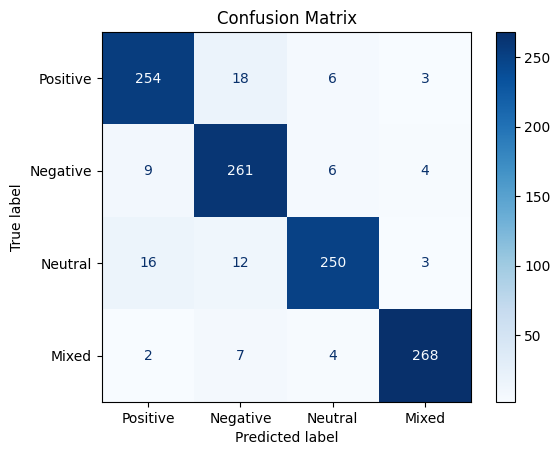

In [ ]:

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=['Positive', 'Negative', 'Neutral', 'Mixed']))
plot_confusion_matrix_fixed(y_test, y_pred_classes)


Savemodel

In [ ]:
save_lstm_model_assets(model, tokenizer, X_test, y_test, 'lstmUnderSampling')

✅ Model saved to: /content/drive/MyDrive/models/lstmUnderSampling/lstmUnderSampling.h5
✅ Tokenizer saved to: /content/drive/MyDrive/models/lstmUnderSampling/lstmUnderSampling_tokenizer.pkl
✅ Test data saved to: /content/drive/MyDrive/models/lstmUnderSampling


# CNN for text

In [ ]:
texts = df['Sentence'].tolist()
labels = df['Label'].tolist()

# Tokenization
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

maxlen = 100
X = pad_sequences(sequences, maxlen=maxlen, padding='post')
y = np.array(labels).astype(int)

In [ ]:
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

print("After Oversampling:", Counter(y_resampled))


After Oversampling: Counter({np.int64(3): 6619, np.int64(2): 6619, np.int64(1): 6619, np.int64(0): 6619})


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.15,
    stratify=y_resampled,
    random_state=42
)


In [ ]:
model = Sequential([
    Embedding(input_dim=20000, output_dim=128),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  # 4 sentiment classes
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.fit(X_train, y_train,
          epochs=8,
          batch_size=64,
          validation_data=(X_test, y_test),
          callbacks=[early_stop])


Epoch 1/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 45s 120ms/step - accuracy: 0.5090 - loss: 1.0763 - val_accuracy: 0.8072 - val_loss: 0.5123
Epoch 2/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 40s 113ms/step - accuracy: 0.8707 - loss: 0.3777 - val_accuracy: 0.8376 - val_loss: 0.4326
Epoch 3/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 41s 116ms/step - accuracy: 0.9393 - loss: 0.1873 - val_accuracy: 0.8492 - val_loss: 0.4394
Epoch 4/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - accuracy: 0.9638 - loss: 0.1094 - val_accuracy: 0.8444 - val_loss: 0.5331


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
              precision    recall  f1-score   support

    Positive       0.81      0.92      0.86       993
    Negative       0.81      0.72      0.76       993
     Neutral       0.80      0.78      0.79       993
       Mixed       0.93      0.94      0.93       993

    accuracy                           0.84      3972
   macro avg       0.84      0.84      0.84      3972
weighted avg       0.84      0.84      0.84      3972



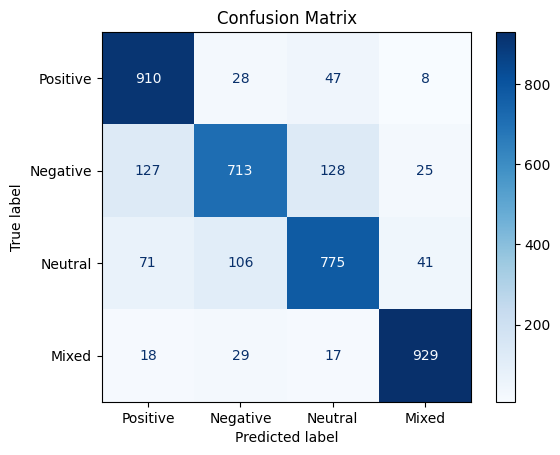

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=["Positive", "Negative", "Neutral", "Mixed"]))
plot_confusion_matrix_fixed(y_test, y_pred_classes)


In [ ]:
save_lstm_model_assets(model, tokenizer, X_test, y_test, 'CNN_OverSampling')

✅ Model saved to: /content/drive/MyDrive/models/CNN_OverSampling/CNN_OverSampling.h5
✅ Tokenizer saved to: /content/drive/MyDrive/models/CNN_OverSampling/CNN_OverSampling_tokenizer.pkl
✅ Test data saved to: /content/drive/MyDrive/models/CNN_OverSampling


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)
print("After undersampling:", Counter(y_resampled))


After undersampling: Counter({np.int64(0): 1871, np.int64(1): 1871, np.int64(2): 1871, np.int64(3): 1871})


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.15,
    stratify=y_resampled,
    random_state=42
)

model.fit(
    X_train, y_train,
    epochs=8,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)


Epoch 1/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.9307 - loss: 0.2267 - val_accuracy: 0.9288 - val_loss: 0.1891
Epoch 2/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 0.9682 - loss: 0.1020 - val_accuracy: 0.9225 - val_loss: 0.2001
Epoch 3/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.9880 - loss: 0.0486 - val_accuracy: 0.9199 - val_loss: 0.2298


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
              precision    recall  f1-score   support

    Positive       0.92      0.92      0.92       281
    Negative       0.92      0.90      0.91       280
     Neutral       0.90      0.94      0.92       281
       Mixed       0.97      0.96      0.97       281

    accuracy                           0.93      1123
   macro avg       0.93      0.93      0.93      1123
weighted avg       0.93      0.93      0.93      1123



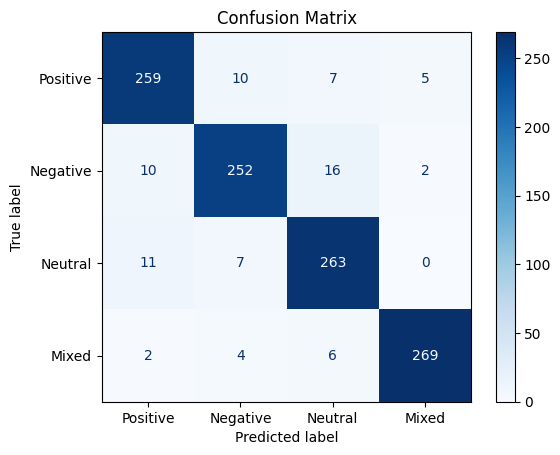

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=["Positive", "Negative", "Neutral", "Mixed"]))
plot_confusion_matrix_fixed(y_test, y_pred_classes)

In [ ]:
save_lstm_model_assets(model, tokenizer, X_test, y_test, 'CNN_UnderSampling')

✅ Model saved to: /content/drive/MyDrive/models/CNN_UnderSampling/CNN_UnderSampling.h5
✅ Tokenizer saved to: /content/drive/MyDrive/models/CNN_UnderSampling/CNN_UnderSampling_tokenizer.pkl
✅ Test data saved to: /content/drive/MyDrive/models/CNN_UnderSampling


# RCNN (Recurrent CNN)

In [ ]:
texts = df['Sentence'].tolist()
labels = df['Label'].tolist()

tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

maxlen = 100
X = pad_sequences(sequences, maxlen=maxlen, padding='post')
y = np.array(labels).astype(int)


In [ ]:
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)
print("Oversampled:", Counter(y_ros))


Oversampled: Counter({np.int64(3): 6619, np.int64(2): 6619, np.int64(1): 6619, np.int64(0): 6619})


In [ ]:
X_used, y_used = X_ros, y_ros
X_train, X_test, y_train, y_test = train_test_split(
    X_used, y_used,
    test_size=0.15,
    stratify=y_used,
    random_state=42
)


In [ ]:
model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=maxlen),
    Bidirectional(LSTM(64, return_sequences=True)),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.fit(X_train, y_train,
          epochs=8,
          batch_size=64,
          validation_data=(X_test, y_test),
          callbacks=[early_stop])


Epoch 1/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 121s 324ms/step - accuracy: 0.5368 - loss: 1.0184 - val_accuracy: 0.8147 - val_loss: 0.5026
Epoch 2/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 113s 321ms/step - accuracy: 0.8754 - loss: 0.3679 - val_accuracy: 0.8409 - val_loss: 0.4551
Epoch 3/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 142s 321ms/step - accuracy: 0.9371 - loss: 0.1977 - val_accuracy: 0.8356 - val_loss: 0.5042
Epoch 4/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 114s 324ms/step - accuracy: 0.9628 - loss: 0.1204 - val_accuracy: 0.8389 - val_loss: 0.5072


125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step
              precision    recall  f1-score   support

    Positive       0.81      0.93      0.87       993
    Negative       0.85      0.73      0.79       993
     Neutral       0.79      0.77      0.78       993
       Mixed       0.91      0.93      0.92       993

    accuracy                           0.84      3972
   macro avg       0.84      0.84      0.84      3972
weighted avg       0.84      0.84      0.84      3972



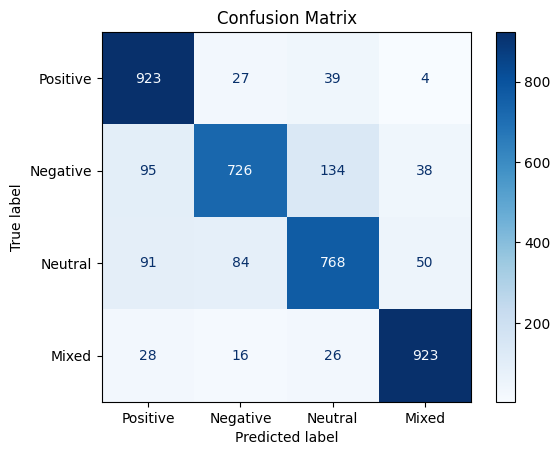

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=["Positive", "Negative", "Neutral", "Mixed"]))
plot_confusion_matrix_fixed(y_test, y_pred_classes)


In [ ]:
save_lstm_model_assets(model, tokenizer, X_test, y_test, 'RCNN_OverSampling')

✅ Model saved to: /content/drive/MyDrive/models/RCNN_OverSampling/RCNN_OverSampling.h5
✅ Tokenizer saved to: /content/drive/MyDrive/models/RCNN_OverSampling/RCNN_OverSampling_tokenizer.pkl
✅ Test data saved to: /content/drive/MyDrive/models/RCNN_OverSampling


In [ ]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_rus, y_rus = rus.fit_resample(X, y)
print("Undersampled:", Counter(y_rus))


Undersampled: Counter({np.int64(0): 1871, np.int64(1): 1871, np.int64(2): 1871, np.int64(3): 1871})


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_used, y_used,
    test_size=0.15,
    stratify=y_used,
    random_state=42
)
model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=maxlen),
    Bidirectional(LSTM(64, return_sequences=True)),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.fit(X_train, y_train,
          epochs=8,
          batch_size=64,
          validation_data=(X_test, y_test),
          callbacks=[early_stop])


Epoch 1/8


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


352/352 ━━━━━━━━━━━━━━━━━━━━ 120s 322ms/step - accuracy: 0.5349 - loss: 1.0317 - val_accuracy: 0.8011 - val_loss: 0.5256
Epoch 2/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 146s 335ms/step - accuracy: 0.8723 - loss: 0.3746 - val_accuracy: 0.8414 - val_loss: 0.4391
Epoch 3/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 114s 323ms/step - accuracy: 0.9416 - loss: 0.1865 - val_accuracy: 0.8376 - val_loss: 0.4847
Epoch 4/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 141s 319ms/step - accuracy: 0.9600 - loss: 0.1170 - val_accuracy: 0.8462 - val_loss: 0.5391


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step
              precision    recall  f1-score   support

    Positive       0.84      0.92      0.88       993
    Negative       0.82      0.71      0.76       993
     Neutral       0.78      0.79      0.79       993
       Mixed       0.92      0.94      0.93       993

    accuracy                           0.84      3972
   macro avg       0.84      0.84      0.84      3972
weighted avg       0.84      0.84      0.84      3972



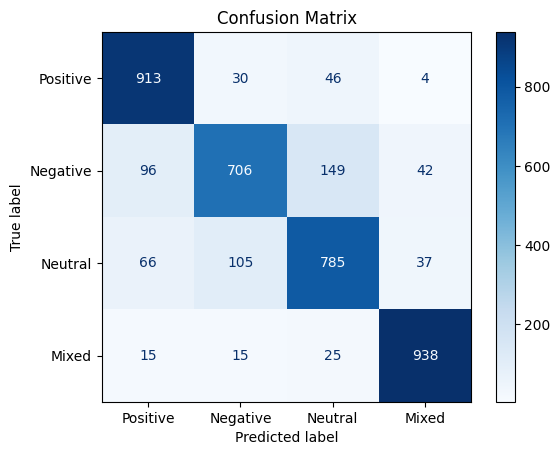

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=["Positive", "Negative", "Neutral", "Mixed"]))
plot_confusion_matrix_fixed(y_test, y_pred_classes)


In [ ]:
save_lstm_model_assets(model, tokenizer, X_test, y_test, 'RCNN_UnderSampling')

✅ Model saved to: /content/drive/MyDrive/models/RCNN_UnderSampling/RCNN_UnderSampling.h5
✅ Tokenizer saved to: /content/drive/MyDrive/models/RCNN_UnderSampling/RCNN_UnderSampling_tokenizer.pkl
✅ Test data saved to: /content/drive/MyDrive/models/RCNN_UnderSampling


# CNN + LSTM Model

Oversampled class counts: Counter({np.int64(3): 6619, np.int64(2): 6619, np.int64(1): 6619, np.int64(0): 6619})
Epoch 1/8


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


352/352 ━━━━━━━━━━━━━━━━━━━━ 87s 236ms/step - accuracy: 0.2504 - loss: 1.3873 - val_accuracy: 0.2500 - val_loss: 1.3864
Epoch 2/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 83s 236ms/step - accuracy: 0.2462 - loss: 1.3874 - val_accuracy: 0.2510 - val_loss: 1.3865
Epoch 3/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 141s 233ms/step - accuracy: 0.2559 - loss: 1.3829 - val_accuracy: 0.4162 - val_loss: 1.2075
Epoch 4/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 144s 238ms/step - accuracy: 0.4084 - loss: 1.1630 - val_accuracy: 0.4277 - val_loss: 1.0781
Epoch 5/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 140s 234ms/step - accuracy: 0.4421 - loss: 1.0500 - val_accuracy: 0.5020 - val_loss: 1.0263
Epoch 6/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 141s 230ms/step - accuracy: 0.5240 - loss: 0.9828 - val_accuracy: 0.5846 - val_loss: 0.9335
Epoch 7/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 82s 231ms/step - accuracy: 0.6213 - loss: 0.8315 - val_accuracy: 0.6294 - val_loss: 0.8192
Epoch 8/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 83s 234ms/step - accuracy: 0.6682 - loss: 0.6867 - val_ac

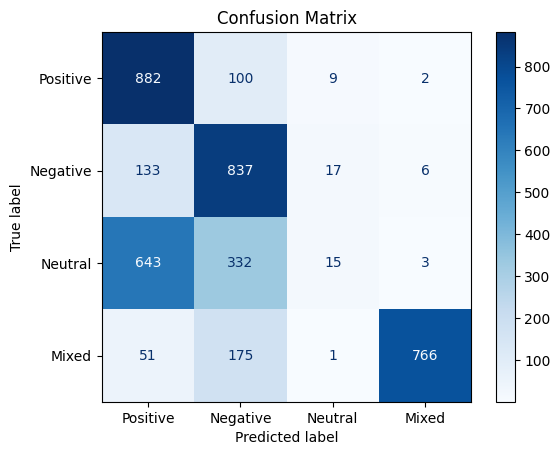

In [ ]:
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

print("Oversampled class counts:", Counter(y_resampled))

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.15,
    stratify=y_resampled,
    random_state=42
)
model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=maxlen),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  # 4 sentiment classes
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()


early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.fit(
    X_train, y_train,
    epochs=8,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=["Positive", "Negative", "Neutral", "Mixed"]))
plot_confusion_matrix_fixed(y_test, y_pred_classes)


In [ ]:
save_lstm_model_assets(model, tokenizer, X_test, y_test, 'CNNxLSTM_OverSampling')

✅ Model saved to: /content/drive/MyDrive/models/CNNxLSTM_OverSampling/CNNxLSTM_OverSampling.h5
✅ Tokenizer saved to: /content/drive/MyDrive/models/CNNxLSTM_OverSampling/CNNxLSTM_OverSampling_tokenizer.pkl
✅ Test data saved to: /content/drive/MyDrive/models/CNNxLSTM_OverSampling


Oversampled class counts: Counter({np.int64(0): 1871, np.int64(1): 1871, np.int64(2): 1871, np.int64(3): 1871})
Epoch 1/8


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 253ms/step - accuracy: 0.2477 - loss: 1.3877 - val_accuracy: 0.2493 - val_loss: 1.3863
Epoch 2/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 239ms/step - accuracy: 0.2565 - loss: 1.3867 - val_accuracy: 0.2502 - val_loss: 1.3867
Epoch 3/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 245ms/step - accuracy: 0.2593 - loss: 1.3864 - val_accuracy: 0.2511 - val_loss: 1.3864
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
              precision    recall  f1-score   support

    Positive       0.00      0.00      0.00       281
    Negative       0.25      1.00      0.40       280
     Neutral       0.00      0.00      0.00       281
       Mixed       0.50      0.00      0.01       281

    accuracy                           0.25      1123
   macro avg       0.19      0.25      0.10      1123
weighted avg       0.19      0.25      0.10      1123



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


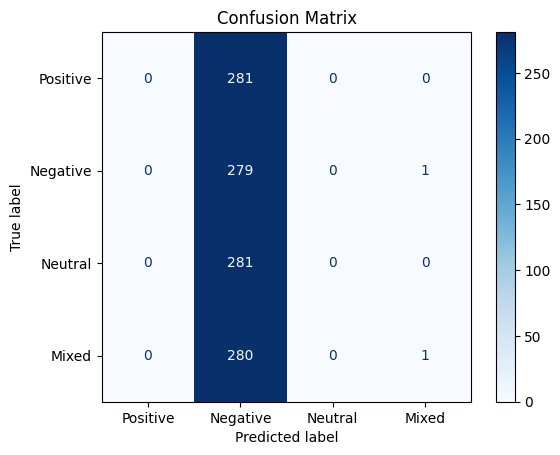

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

print("Oversampled class counts:", Counter(y_resampled))

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.15,
    stratify=y_resampled,
    random_state=42
)
model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=maxlen),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  # 4 sentiment classes
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()


early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.fit(
    X_train, y_train,
    epochs=8,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=["Positive", "Negative", "Neutral", "Mixed"]))
plot_confusion_matrix_fixed(y_test, y_pred_classes)


In [ ]:
save_lstm_model_assets(model, tokenizer, X_test, y_test, 'CNNxLSTM_UnderSampling')

✅ Model saved to: /content/drive/MyDrive/models/CNNxLSTM_UnderSampling/CNNxLSTM_UnderSampling.h5
✅ Tokenizer saved to: /content/drive/MyDrive/models/CNNxLSTM_UnderSampling/CNNxLSTM_UnderSampling_tokenizer.pkl
✅ Test data saved to: /content/drive/MyDrive/models/CNNxLSTM_UnderSampling


#  **ML ALGOS**

# ✅ Logistic Regression (with class weight balancing)

In [ ]:

# Clean text
df['Sentence'] = df['Sentence'].astype(str)
df['Label'] = df['Label'].astype(int)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=3)
X = vectorizer.fit_transform(df['Sentence'])
y = df['Label'].values

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

print("After Oversampling:", Counter(y_resampled))

# Then split and train as usual
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.15,
    stratify=y_resampled,
    random_state=42
)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

After Oversampling: Counter({np.int64(3): 6619, np.int64(2): 6619, np.int64(1): 6619, np.int64(0): 6619})


LogisticRegression(max_iter=1000)

              precision    recall  f1-score   support

    Positive       0.84      0.83      0.84       993
    Negative       0.75      0.75      0.75       993
     Neutral       0.70      0.71      0.71       993
       Mixed       0.87      0.87      0.87       993

    accuracy                           0.79      3972
   macro avg       0.79      0.79      0.79      3972
weighted avg       0.79      0.79      0.79      3972



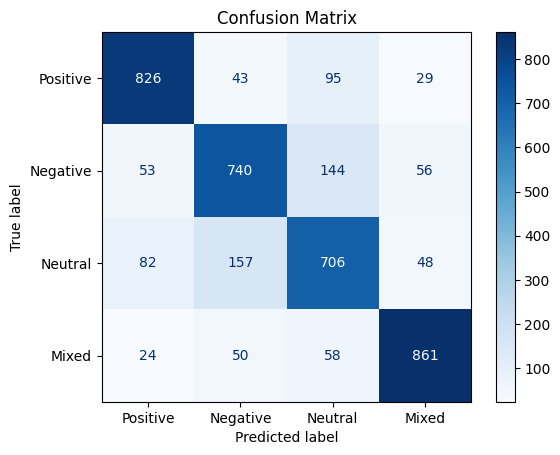

In [ ]:
y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Positive', 'Negative', 'Neutral', 'Mixed']))
plot_confusion_matrix_fixed(y_test, y_pred)

In [ ]:
save_ml_model_assets(model, X_test, y_test, 'Logistic_Regression_Over')

✅ ML Model saved to: /content/drive/MyDrive/models/Logistic_Regression_Over/Logistic_Regression_Over_model.pkl
✅ Test data saved to: /content/drive/MyDrive/models/Logistic_Regression_Over


In [ ]:

# Clean text
df['Sentence'] = df['Sentence'].astype(str)
df['Label'] = df['Label'].astype(int)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=3)
X = vectorizer.fit_transform(df['Sentence'])
y = df['Label'].values

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

print("After undersampling:", Counter(y_resampled))

# Then split and train as usual
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.15,
    stratify=y_resampled,
    random_state=42
)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

After undersampling: Counter({np.int64(0): 1871, np.int64(1): 1871, np.int64(2): 1871, np.int64(3): 1871})


LogisticRegression(max_iter=1000)

              precision    recall  f1-score   support

    Positive       0.70      0.69      0.70       281
    Negative       0.60      0.66      0.63       280
     Neutral       0.62      0.72      0.67       281
       Mixed       0.73      0.56      0.63       281

    accuracy                           0.66      1123
   macro avg       0.66      0.66      0.66      1123
weighted avg       0.66      0.66      0.66      1123



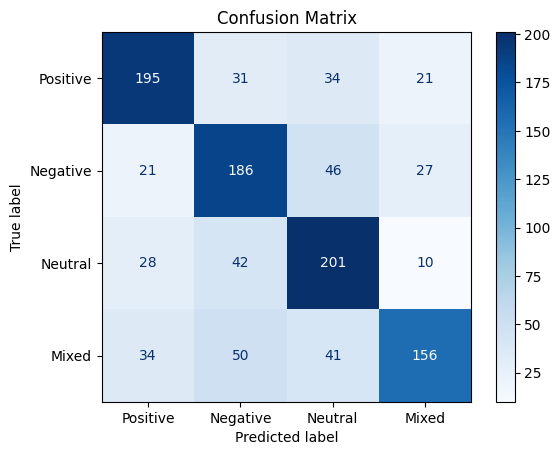

In [ ]:
y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Positive', 'Negative', 'Neutral', 'Mixed']))
plot_confusion_matrix_fixed(y_test, y_pred)

In [ ]:
save_ml_model_assets(model,  X_test, y_test, 'Logistic_Regression_Under')

✅ ML Model saved to: /content/drive/MyDrive/models/Logistic_Regression_Under/Logistic_Regression_Under_model.pkl
✅ Test data saved to: /content/drive/MyDrive/models/Logistic_Regression_Under


# ✅ SVM + TF-IDF + Oversampling

In [ ]:


df['Sentence'] = df['Sentence'].astype(str)
df['Label'] = df['Label'].astype(int)

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=3)
X = vectorizer.fit_transform(df['Sentence'])
y = df['Label'].values

ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

print("After Oversampling:", Counter(y_resampled))

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.15,
    stratify=y_resampled,
    random_state=42
)
svm_model = SVC(kernel='linear', probability=True)  # 'linear' is best for text data
svm_model.fit(X_train, y_train)

After Oversampling: Counter({np.int64(3): 6619, np.int64(2): 6619, np.int64(1): 6619, np.int64(0): 6619})
              precision    recall  f1-score   support

    Positive       0.84      0.86      0.85       993
    Negative       0.76      0.75      0.75       993
     Neutral       0.74      0.71      0.73       993
       Mixed       0.88      0.92      0.90       993

    accuracy                           0.81      3972
   macro avg       0.81      0.81      0.81      3972
weighted avg       0.81      0.81      0.81      3972



ValueError: Found input variables with inconsistent numbers of samples: [3972, 1123]

              precision    recall  f1-score   support

    Positive       0.84      0.86      0.85       993
    Negative       0.76      0.75      0.75       993
     Neutral       0.74      0.71      0.73       993
       Mixed       0.88      0.92      0.90       993

    accuracy                           0.81      3972
   macro avg       0.81      0.81      0.81      3972
weighted avg       0.81      0.81      0.81      3972



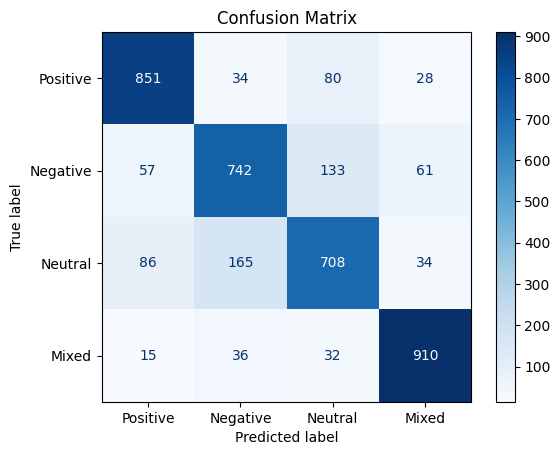

In [ ]:
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Positive", "Negative", "Neutral", "Mixed"]))
plot_confusion_matrix_fixed(y_test, y_pred)

In [ ]:
save_ml_model_assets(model,  X_test, y_test, 'SVM_Over')

✅ ML Model saved to: /content/drive/MyDrive/models/SVM_Over/SVM_Over_model.pkl
✅ Test data saved to: /content/drive/MyDrive/models/SVM_Over


After undersampling: Counter({np.int64(0): 1871, np.int64(1): 1871, np.int64(2): 1871, np.int64(3): 1871})
              precision    recall  f1-score   support

    Positive       0.68      0.68      0.68       281
    Negative       0.60      0.63      0.61       280
     Neutral       0.61      0.72      0.66       281
       Mixed       0.70      0.55      0.62       281

    accuracy                           0.64      1123
   macro avg       0.65      0.64      0.64      1123
weighted avg       0.65      0.64      0.64      1123



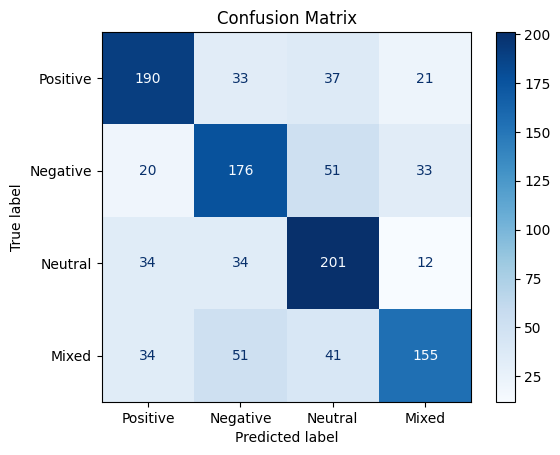

In [ ]:
df['Sentence'] = df['Sentence'].astype(str)

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=3)
X = vectorizer.fit_transform(df['Sentence'])
y = df['Label'].values

rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)
print("After undersampling:", Counter(y_resampled))

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.15,
    stratify=y_resampled,
    random_state=42
)
svm_model = SVC(kernel='linear', probability=True)  # 'linear' is best for text data
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Positive", "Negative", "Neutral", "Mixed"]))
plot_confusion_matrix_fixed(y_test, y_pred)

In [ ]:
save_ml_model_assets(model,  X_test, y_test, 'SVM_Under')

✅ ML Model saved to: /content/drive/MyDrive/models/SVM_Under/SVM_Under_model.pkl
✅ Test data saved to: /content/drive/MyDrive/models/SVM_Under


# ✅ Random Forest + TF-IDF + Oversampling

In [ ]:
df['Sentence'] = df['Sentence'].astype(str)
df['Label'] = df['Label'].astype(int)
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=3)
X = vectorizer.fit_transform(df['Sentence'])
y = df['Label'].values

In [ ]:
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

print("After Oversampling:", Counter(y_resampled))

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.15,
    stratify=y_resampled,
    random_state=42
)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["Positive", "Negative", "Neutral", "Mixed"]))
plot_confusion_matrix_fixed(y_test, y_pred_classes)

After Oversampling: Counter({np.int64(3): 6619, np.int64(2): 6619, np.int64(1): 6619, np.int64(0): 6619})
              precision    recall  f1-score   support

    Positive       0.85      0.93      0.89       993
    Negative       0.77      0.75      0.76       993
     Neutral       0.77      0.70      0.73       993
       Mixed       0.95      0.98      0.97       993

    accuracy                           0.84      3972
   macro avg       0.84      0.84      0.84      3972
weighted avg       0.84      0.84      0.84      3972



ValueError: Found input variables with inconsistent numbers of samples: [3972, 1123]

In [ ]:
save_ml_model_assets(model,  X_test, y_test, 'RandomForest_Over')

After UnderSampling: Counter({np.int64(0): 1871, np.int64(1): 1871, np.int64(2): 1871, np.int64(3): 1871})
              precision    recall  f1-score   support

    Positive       0.65      0.64      0.65       281
    Negative       0.56      0.62      0.59       280
     Neutral       0.58      0.69      0.63       281
       Mixed       0.75      0.54      0.63       281

    accuracy                           0.62      1123
   macro avg       0.63      0.62      0.62      1123
weighted avg       0.63      0.62      0.62      1123



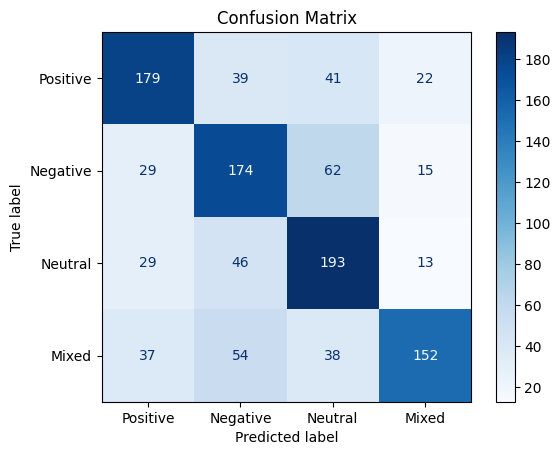

In [ ]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

print("After UnderSampling:", Counter(y_resampled))

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.15,
    stratify=y_resampled,
    random_state=42
)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["Positive", "Negative", "Neutral", "Mixed"]))
plot_confusion_matrix_fixed(y_test, y_pred)



In [ ]:
save_ml_model_assets(model,  X_test, y_test, 'RandomForest_Under')

✅ ML Model saved to: /content/drive/MyDrive/models/RandomForest_Under/RandomForest_Under_model.pkl
✅ Test data saved to: /content/drive/MyDrive/models/RandomForest_Under


# ✅ Naive Bayes + TF-IDF + Oversampling

In [ ]:
df['Sentence'] = df['Sentence'].astype(str)
df['Label'] = df['Label'].astype(int)
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=3)
X = vectorizer.fit_transform(df['Sentence'])
y = df['Label'].values

After Oversampling: Counter({np.int64(3): 6619, np.int64(2): 6619, np.int64(1): 6619, np.int64(0): 6619})
              precision    recall  f1-score   support

    Positive       0.69      0.65      0.67       281
    Negative       0.65      0.62      0.64       280
     Neutral       0.64      0.69      0.66       281
       Mixed       0.58      0.59      0.59       281

    accuracy                           0.64      1123
   macro avg       0.64      0.64      0.64      1123
weighted avg       0.64      0.64      0.64      1123



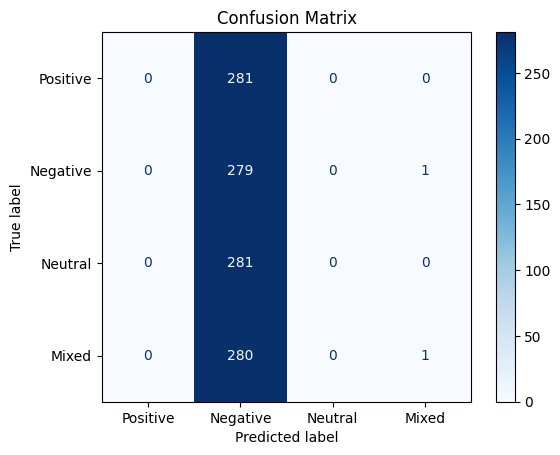

In [ ]:
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

print("After Oversampling:", Counter(y_resampled))

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["Positive", "Negative", "Neutral", "Mixed"]))
plot_confusion_matrix_fixed(y_test, y_pred_classes)


In [ ]:
save_ml_model_assets(model,  X_test, y_test, 'NaiveBayes_Over')

✅ ML Model saved to: /content/drive/MyDrive/models/NaiveBayes_Over/NaiveBayes_Over_model.pkl
✅ Test data saved to: /content/drive/MyDrive/models/NaiveBayes_Over


After UnderSampling: Counter({np.int64(0): 1871, np.int64(1): 1871, np.int64(2): 1871, np.int64(3): 1871})
              precision    recall  f1-score   support

    Positive       0.69      0.65      0.67       281
    Negative       0.65      0.62      0.64       280
     Neutral       0.64      0.69      0.66       281
       Mixed       0.58      0.59      0.59       281

    accuracy                           0.64      1123
   macro avg       0.64      0.64      0.64      1123
weighted avg       0.64      0.64      0.64      1123



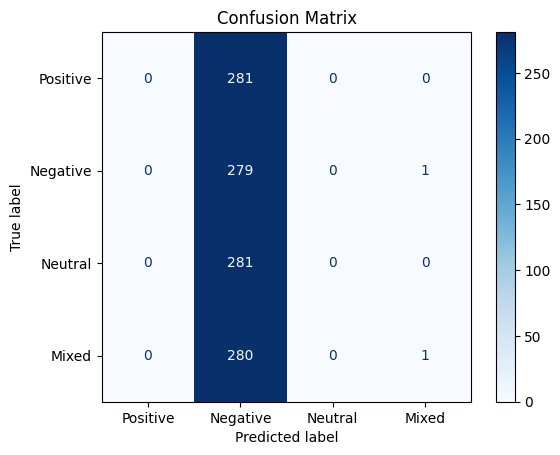

In [ ]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

print("After UnderSampling:", Counter(y_resampled))

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["Positive", "Negative", "Neutral", "Mixed"]))
plot_confusion_matrix_fixed(y_test, y_pred_classes)


In [ ]:
save_ml_model_assets(model,  X_test, y_test, 'NaiveBayes_Under')

✅ ML Model saved to: /content/drive/MyDrive/models/NaiveBayes_Under/NaiveBayes_Under_model.pkl
✅ Test data saved to: /content/drive/MyDrive/models/NaiveBayes_Under


# ✅ XGBoost + TF-IDF + Oversampling

In [ ]:
df['Sentence'] = df['Sentence'].astype(str)
df['Label'] = df['Label'].astype(int)

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=3)
X = vectorizer.fit_transform(df['Sentence'])
y = df['Label'].values

After Oversampling: Counter({np.int64(3): 6619, np.int64(2): 6619, np.int64(1): 6619, np.int64(0): 6619})
              precision    recall  f1-score   support

    Positive       0.81      0.76      0.79       993
    Negative       0.66      0.72      0.69       993
     Neutral       0.68      0.68      0.68       993
       Mixed       0.87      0.83      0.85       993

    accuracy                           0.75      3972
   macro avg       0.75      0.75      0.75      3972
weighted avg       0.75      0.75      0.75      3972



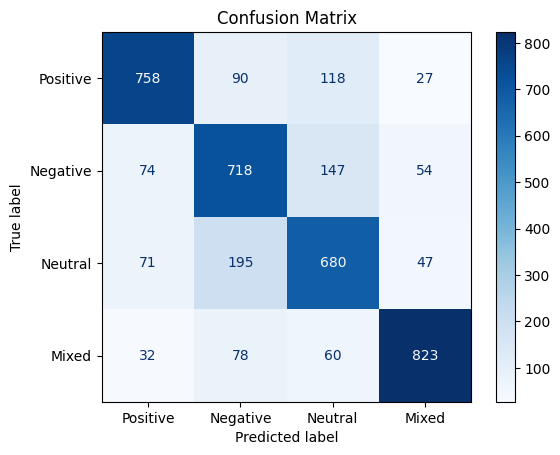

In [ ]:
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

print("After Oversampling:", Counter(y_resampled))

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.15,
    stratify=y_resampled,
    random_state=42
)
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    eval_metric='mlogloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Positive", "Negative", "Neutral", "Mixed"]))
plot_confusion_matrix_fixed(y_test, y_pred)


In [ ]:
save_ml_model_assets(model,  X_test, y_test, 'XGBoost_Over')

✅ ML Model saved to: /content/drive/MyDrive/models/XGBoost_Over/XGBoost_Over_model.pkl
✅ Test data saved to: /content/drive/MyDrive/models/XGBoost_Over


After UnderSampling: Counter({np.int64(0): 1871, np.int64(1): 1871, np.int64(2): 1871, np.int64(3): 1871})
              precision    recall  f1-score   support

    Positive       0.67      0.58      0.62       281
    Negative       0.58      0.65      0.61       280
     Neutral       0.60      0.68      0.63       281
       Mixed       0.66      0.58      0.62       281

    accuracy                           0.62      1123
   macro avg       0.63      0.62      0.62      1123
weighted avg       0.63      0.62      0.62      1123



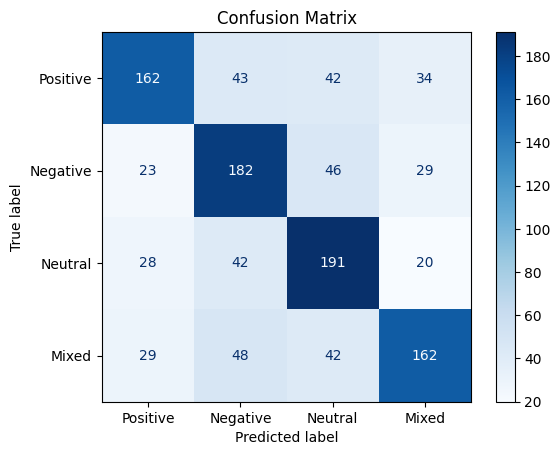

In [ ]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

print("After UnderSampling:", Counter(y_resampled))



X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.15,
    stratify=y_resampled,
    random_state=42
)
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    eval_metric='mlogloss',

    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Positive", "Negative", "Neutral", "Mixed"]))
plot_confusion_matrix_fixed(y_test, y_pred)


In [ ]:
save_ml_model_assets(model,  X_test, y_test, 'XGBoost_Under')

✅ ML Model saved to: /content/drive/MyDrive/models/XGBoost_Under/XGBoost_Under_model.pkl
✅ Test data saved to: /content/drive/MyDrive/models/XGBoost_Under


#Hybrids ii

# 🔁 CNN + BiLSTM (Deep Hybrid)



===== Training with Sampler: Original =====
Epoch 1/8
266/266 - 92s - 347ms/step - accuracy: 0.6394 - loss: 0.8696 - val_accuracy: 0.7486 - val_loss: 0.6485
Epoch 2/8
266/266 - 145s - 544ms/step - accuracy: 0.8333 - loss: 0.4728 - val_accuracy: 0.7496 - val_loss: 0.6831
Epoch 3/8
266/266 - 139s - 523ms/step - accuracy: 0.9007 - loss: 0.2834 - val_accuracy: 0.7416 - val_loss: 0.7604
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step

Classification Report for Original:
              precision    recall  f1-score   support

    Positive       0.81      0.76      0.78       803
    Negative       0.78      0.68      0.73       926
     Neutral       0.70      0.84      0.77       993
       Mixed       0.69      0.59      0.63       281

    accuracy                           0.75      3003
   macro avg       0.74      0.72      0.73      3003
weighted avg       0.75      0.75      0.75      3003



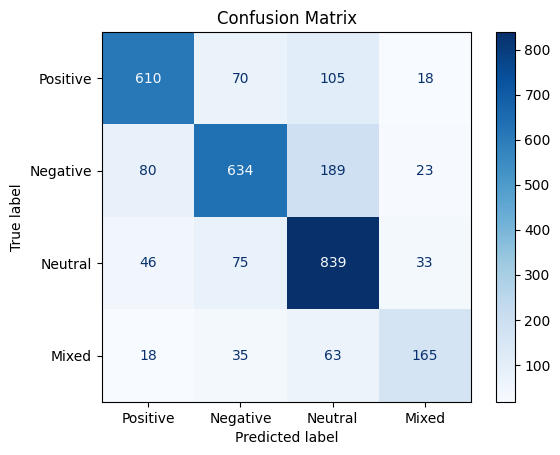

✅ Model saved to: /content/drive/MyDrive/models/CNN_BiLSTM_Original/CNN_BiLSTM_Original.h5
✅ Tokenizer saved to: /content/drive/MyDrive/models/CNN_BiLSTM_Original/CNN_BiLSTM_Original_tokenizer.pkl
✅ Test data saved to: /content/drive/MyDrive/models/CNN_BiLSTM_Original


===== Training with Sampler: RandomOverSampler =====
Epoch 1/8
352/352 - 137s - 388ms/step - accuracy: 0.6665 - loss: 0.8004 - val_accuracy: 0.8112 - val_loss: 0.5186
Epoch 2/8
352/352 - 133s - 379ms/step - accuracy: 0.8688 - loss: 0.3731 - val_accuracy: 0.8411 - val_loss: 0.4389
Epoch 3/8
352/352 - 135s - 385ms/step - accuracy: 0.9285 - loss: 0.2159 - val_accuracy: 0.8426 - val_loss: 0.5094
Epoch 4/8
352/352 - 144s - 408ms/step - accuracy: 0.9533 - loss: 0.1426 - val_accuracy: 0.8464 - val_loss: 0.5361
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step

Classification Report for RandomOverSampler:
              precision    recall  f1-score   support

    Positive       0.84      0.90      0.87       993
    Negative       0.81

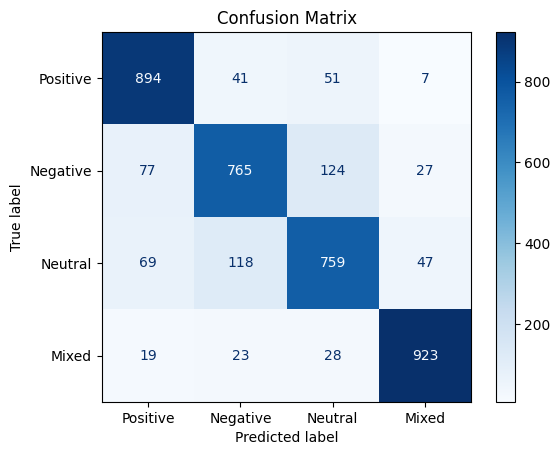

✅ Model saved to: /content/drive/MyDrive/models/CNN_BiLSTM_RandomOverSampler/CNN_BiLSTM_RandomOverSampler.h5
✅ Tokenizer saved to: /content/drive/MyDrive/models/CNN_BiLSTM_RandomOverSampler/CNN_BiLSTM_RandomOverSampler_tokenizer.pkl
✅ Test data saved to: /content/drive/MyDrive/models/CNN_BiLSTM_RandomOverSampler


===== Training with Sampler: RandomUnderSampler =====
Epoch 1/8
100/100 - 40s - 405ms/step - accuracy: 0.4498 - loss: 1.1544 - val_accuracy: 0.5654 - val_loss: 0.9656
Epoch 2/8
100/100 - 32s - 317ms/step - accuracy: 0.7269 - loss: 0.6909 - val_accuracy: 0.6616 - val_loss: 0.8531
Epoch 3/8
100/100 - 32s - 318ms/step - accuracy: 0.8856 - loss: 0.3315 - val_accuracy: 0.6563 - val_loss: 1.0318
Epoch 4/8
100/100 - 33s - 330ms/step - accuracy: 0.9459 - loss: 0.1601 - val_accuracy: 0.6492 - val_loss: 1.2709
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step

Classification Report for RandomUnderSampler:
              precision    recall  f1-score   support

    Positive       0.68      0.59   

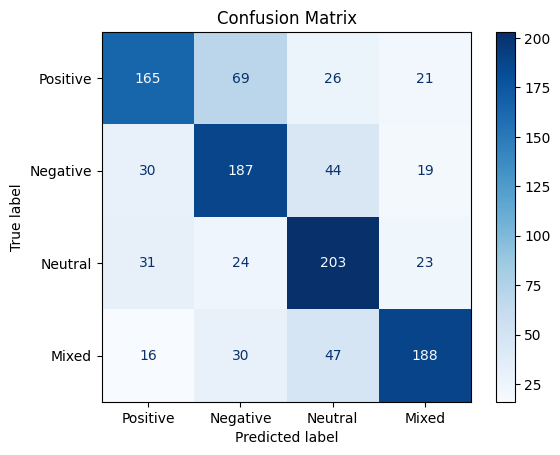

✅ Model saved to: /content/drive/MyDrive/models/CNN_BiLSTM_RandomUnderSampler/CNN_BiLSTM_RandomUnderSampler.h5
✅ Tokenizer saved to: /content/drive/MyDrive/models/CNN_BiLSTM_RandomUnderSampler/CNN_BiLSTM_RandomUnderSampler_tokenizer.pkl
✅ Test data saved to: /content/drive/MyDrive/models/CNN_BiLSTM_RandomUnderSampler


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, SpatialDropout1D, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

# --- Prepare Data ---
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Sentence'].tolist())
sequences = tokenizer.texts_to_sequences(df['Sentence'].tolist())
X = pad_sequences(sequences, maxlen=100, padding='post')
y = np.array(df['Label'])

# --- Define Samplers ---
from collections import OrderedDict
from imblearn.combine import SMOTEENN

samplers = OrderedDict({
    'Original': None,  # No sampling
    'RandomOverSampler': RandomOverSampler(random_state=42),
    'RandomUnderSampler': RandomUnderSampler(random_state=42),

})

# --- Loop Through Samplers ---
for name, sampler in samplers.items():
    print(f"\n\n===== Training with Sampler: {name} =====")

    # Apply sampler if not None
    if sampler is not None:
        X_res, y_res = sampler.fit_resample(X, y)
    else:
        X_res, y_res = X, y  # No resampling

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_res, y_res, test_size=0.15, stratify=y_res, random_state=42
    )

    # Build Model
    model = Sequential([
        Embedding(20000, 128),
        Conv1D(128, kernel_size=3, activation='relu'),
        SpatialDropout1D(0.3),
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(4, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

    model.fit(X_train, y_train, epochs=8, batch_size=64,
              validation_data=(X_test, y_test),
              callbacks=[early_stop],
              verbose=2)

    # Evaluate
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred_classes, target_names=["Positive", "Negative", "Neutral", "Mixed"]))
    plot_confusion_matrix_fixed(y_test, y_pred_classes)
    save_lstm_model_assets(model, tokenizer, X_test, y_test, f'CNN_BiLSTM_{name}')

# 🔁 RCNN + Attention (DL Hybrid)

Epoch 1/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 350ms/step - accuracy: 0.3897 - loss: 1.2664 - val_accuracy: 0.6607 - val_loss: 0.8546
Epoch 2/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 345ms/step - accuracy: 0.7902 - loss: 0.5693 - val_accuracy: 0.6901 - val_loss: 0.8318
Epoch 3/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 334ms/step - accuracy: 0.9232 - loss: 0.2444 - val_accuracy: 0.6794 - val_loss: 1.0360
Epoch 4/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 342ms/step - accuracy: 0.9719 - loss: 0.0951 - val_accuracy: 0.6705 - val_loss: 1.3671
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
              precision    recall  f1-score   support

    Positive       0.72      0.73      0.72       281
    Negative       0.63      0.71      0.67       280
     Neutral       0.67      0.71      0.69       281
       Mixed       0.76      0.61      0.68       281

    accuracy                           0.69      1123
   macro avg       0.70      0.69      0.69      1123
weighted avg       0.70      0.69      0.69      1123



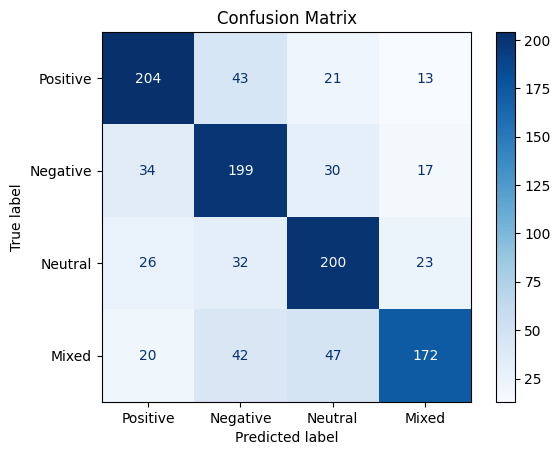

✅ Model saved to: /content/drive/MyDrive/models/RCNN_Attention/RCNN_Attention.h5
✅ Tokenizer saved to: /content/drive/MyDrive/models/RCNN_Attention/RCNN_Attention_tokenizer.pkl
✅ Test data saved to: /content/drive/MyDrive/models/RCNN_Attention


In [ ]:
from tensorflow.keras.layers import Attention, Input
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)
class_weights_dict = dict(enumerate(class_weights))

input_layer = Input(shape=(100,))
embed = Embedding(20000, 128)(input_layer)
bilstm = Bidirectional(LSTM(64, return_sequences=True))(embed)
conv = Conv1D(128, kernel_size=3, activation='relu')(bilstm)
attn_output = GlobalMaxPooling1D()(conv)
drop = Dropout(0.3)(attn_output)
dense = Dense(64, activation='relu')(drop)
output = Dense(4, activation='softmax')(dense)

rcnn_attn_model = Model(inputs=input_layer, outputs=output)
rcnn_attn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

rcnn_attn_model.fit(X_train, y_train, epochs=8, batch_size=64,
                    validation_data=(X_test, y_test),
                    class_weight=class_weights_dict,
                    callbacks=[early_stop])

y_pred = rcnn_attn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=["Positive", "Negative", "Neutral", "Mixed"]))
plot_confusion_matrix_fixed(y_test, y_pred_classes)
save_lstm_model_assets(model, tokenizer, X_test, y_test, 'RCNN_Attention')


# 🔁 Stacking (LogReg + SVM + RF + Meta Classifier)

              precision    recall  f1-score   support

    Positive       0.86      0.92      0.89       993
    Negative       0.80      0.77      0.78       993
     Neutral       0.78      0.74      0.76       993
       Mixed       0.97      0.98      0.97       993

    accuracy                           0.85      3972
   macro avg       0.85      0.85      0.85      3972
weighted avg       0.85      0.85      0.85      3972



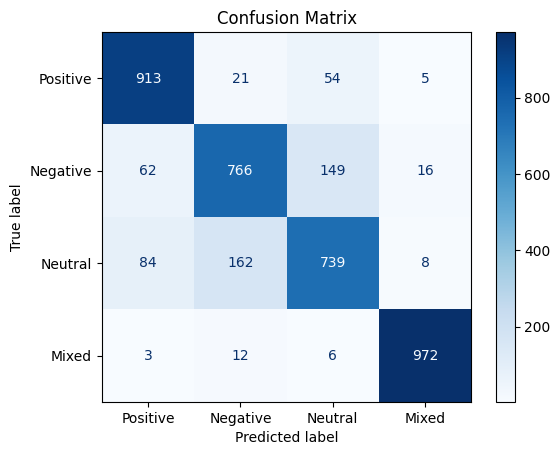

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Vectorize
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=3)
X = vectorizer.fit_transform(df['Sentence'])
y = df['Label'].values

# Oversample
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.15, stratify=y_resampled, random_state=42)

# Define base learners
estimators = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('svm', SVC(kernel='linear', probability=True)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
]

# Stacking classifier
stack_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

stack_model.fit(X_train, y_train)
y_pred = stack_model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["Positive", "Negative", "Neutral", "Mixed"]))
plot_confusion_matrix_fixed(y_test, y_pred)

In [ ]:
save_lstm_model_assets(model, tokenizer, X_test, y_test, 'Stacking_LogReg_SVM_RF')

✅ Model saved to: /content/drive/MyDrive/models/Stacking_LogReg_SVM_RF/Stacking_LogReg_SVM_RF.h5
✅ Tokenizer saved to: /content/drive/MyDrive/models/Stacking_LogReg_SVM_RF/Stacking_LogReg_SVM_RF_tokenizer.pkl
✅ Test data saved to: /content/drive/MyDrive/models/Stacking_LogReg_SVM_RF


#Load Models

In [ ]:
load_and_evaluate_lstm_model('lstmUnderSampling', target_names=['Positive', 'Negative', 'Neutral', 'Mixed'])

In [ ]:
load_and_evaluate_ml_model('XGBoost_Under', target_names=['Positive', 'Negative', 'Neutral', 'Mixed'])


# Bert Multilingual

In [ ]:
!pip install transformers scikit-learn torch

In [ ]:
df['Sentence'] = df['Sentence'].astype(str)
df['Label'] = df['Label'].astype(int)

# Train/test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Sentence'].tolist(),
    df['Label'].tolist(),
    test_size=0.15,
    stratify=df['Label'],
    random_state=42
)

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)


In [ ]:
import torch

class BanglishDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx]) for key, val in self.encodings.items()
        } | {'labels': torch.tensor(self.labels[idx])}
    def __len__(self):
        return len(self.labels)

train_dataset = BanglishDataset(train_encodings, train_labels)
test_dataset = BanglishDataset(test_encodings, test_labels)


In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=4  # 4 sentiment classes
)


In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    eval_strategy="epoch",  # Corrected argument name
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
)

def compute_metrics(eval_pred):
    from sklearn.metrics import classification_report
    import numpy as np
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    report = classification_report(labels, preds, output_dict=True)
    return {
        "accuracy": report["accuracy"],
        "f1_macro": report["macro avg"]["f1-score"],
        "f1_weighted": report["weighted avg"]["f1-score"]
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [ ]:
results = trainer.evaluate()
print(results)


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)